In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pygsheets
import pandas as pd
import sys
import inspect
from datetime import datetime, timedelta

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import fit_and_predict_ensemble
from functions import merge_data
from viz import  viz_interactive
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from functions import merge_data
from fit_and_predict import add_preds
from update_severity_index import df_to_plot, add_severity_index

Loading BokehJS ...

# county-level plot

In [ ]:
print('loading data...')
NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))


num_days_in_past = 3
output_key = f'Predicted Deaths {num_days_in_past}-day'    
df_county = fit_and_predict_ensemble(df_county, 
                            outcome='deaths',
                            mode='eval_mode',
                            target_day=np.array([num_days_in_past]),
                            output_key=output_key)
df_county[output_key] = [v[0] for v in df_county[output_key].values]

In [16]:
# update_modeling_results.predictions_plot(df_county, NUM_DAYS_LIST, num_days_in_past, output_key)

Loading BokehJS ...

In [ ]:
today = datetime.today().strftime("%B %d")
plt.figure(dpi=500)
day_past = (datetime.now() - timedelta(days=3)).strftime("%B %d")
plt.plot([0, max(df_county[output_key])], [0, max(df_county[output_key])], 
         '--', color='gray')
plt.plot(df_county['tot_deaths'], 
         df_county[output_key], '.')

plt.xlabel(f'Actual deaths by {today}')
plt.ylabel(f'Predicted deaths by {today}\n(predicted on {day_past})')
plt.xscale('log')
plt.yscale('log')
plt.show()

# hospital-level plot

In [3]:
NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))
df_hospital = load_data.load_hospital_level(data_dir=oj(parentdir, 'data_hospital_level'))
df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST, cached_dir=oj(parentdir, 'data')) # adds keys like "Predicted Deaths 1-day"
df = merge_data.merge_county_and_hosp(df_county, df_hospital)
df = add_severity_index(df, NUM_DAYS_LIST)
df = df.sort_values('Total Deaths Hospital', ascending=False)

In [4]:
d = df_to_plot(df, NUM_DAYS_LIST)
# viz_interactive.viz_index_animated(d, [1, 3, 5],
#                                    out_name=oj(parentdir, 'results', 'hospital_index_animated.html'))    

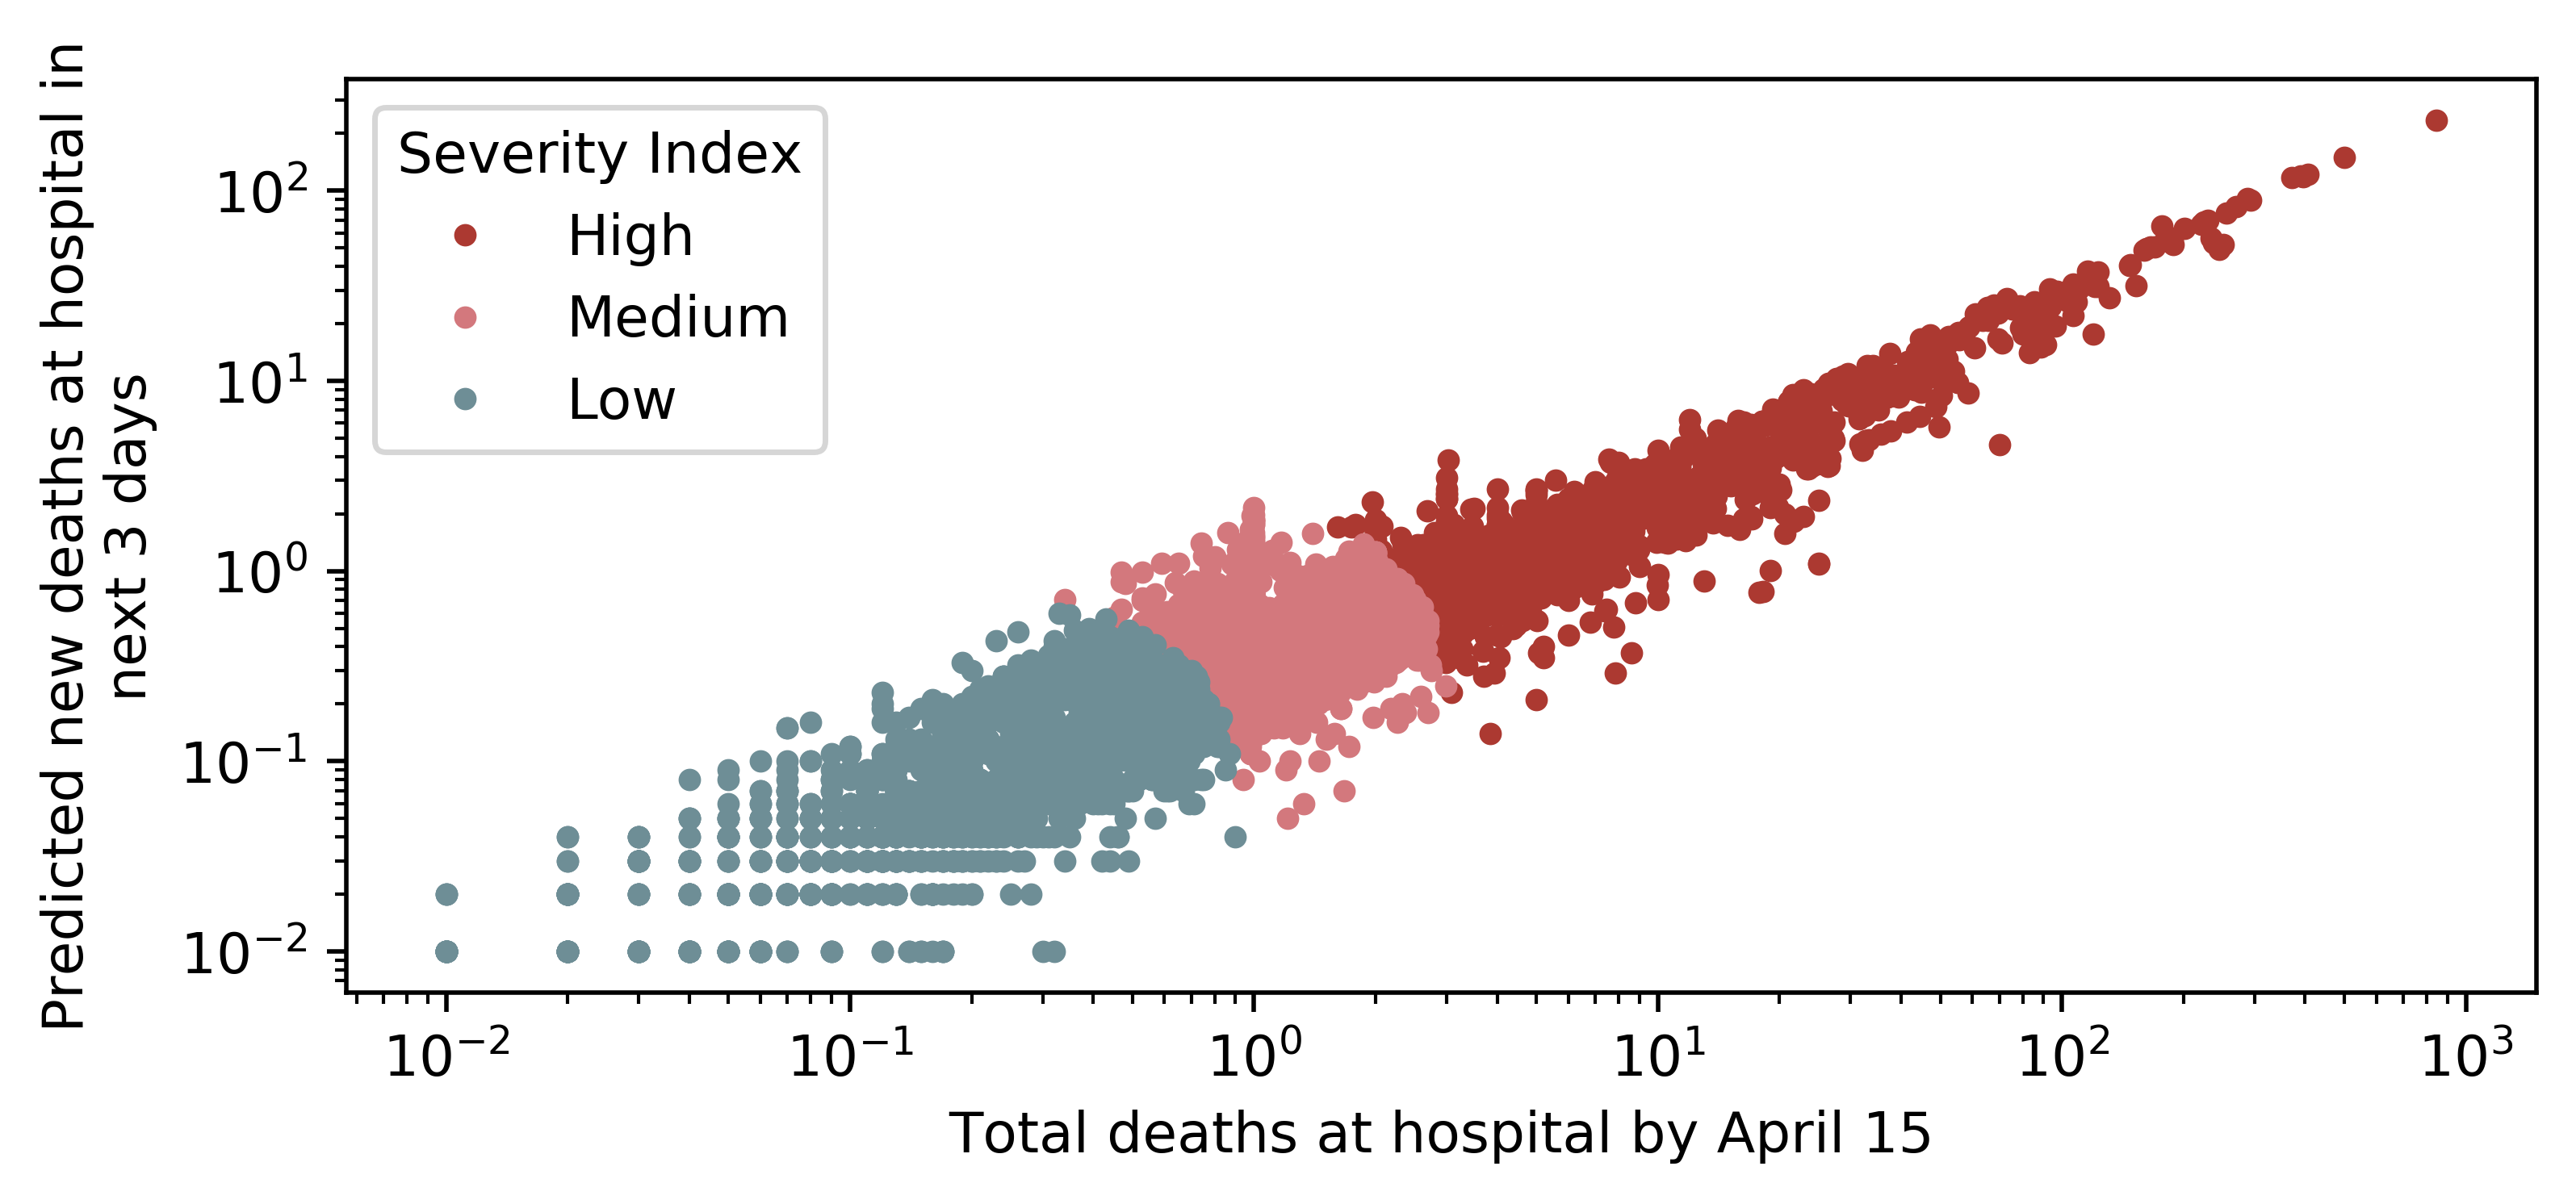

In [10]:
today = datetime.today().strftime("%B %d")
plt.figure(dpi=500, figsize=(7, 3))
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
# cs = ['b','#dec34b','r']
cs = ['#6E8E96', '#D3787D', '#AC3931']
# cs = ['#91bfdb','#dec34b','#fc8d59']
for i in [3, 2, 1]:
    dr = d[d['Severity 3-day']==i]
    plt.plot(dr['Total Deaths Hospital'], 
             dr['Predicted New Deaths Hospital 3-day'], '.',
             label=f'{remap[i]}', alpha=1, color=cs[i -1])
plt.xlabel(f'Total deaths at hospital by {today}')
plt.ylabel('Predicted new deaths at hospital in\nnext 3 days')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Severity Index')
plt.show()

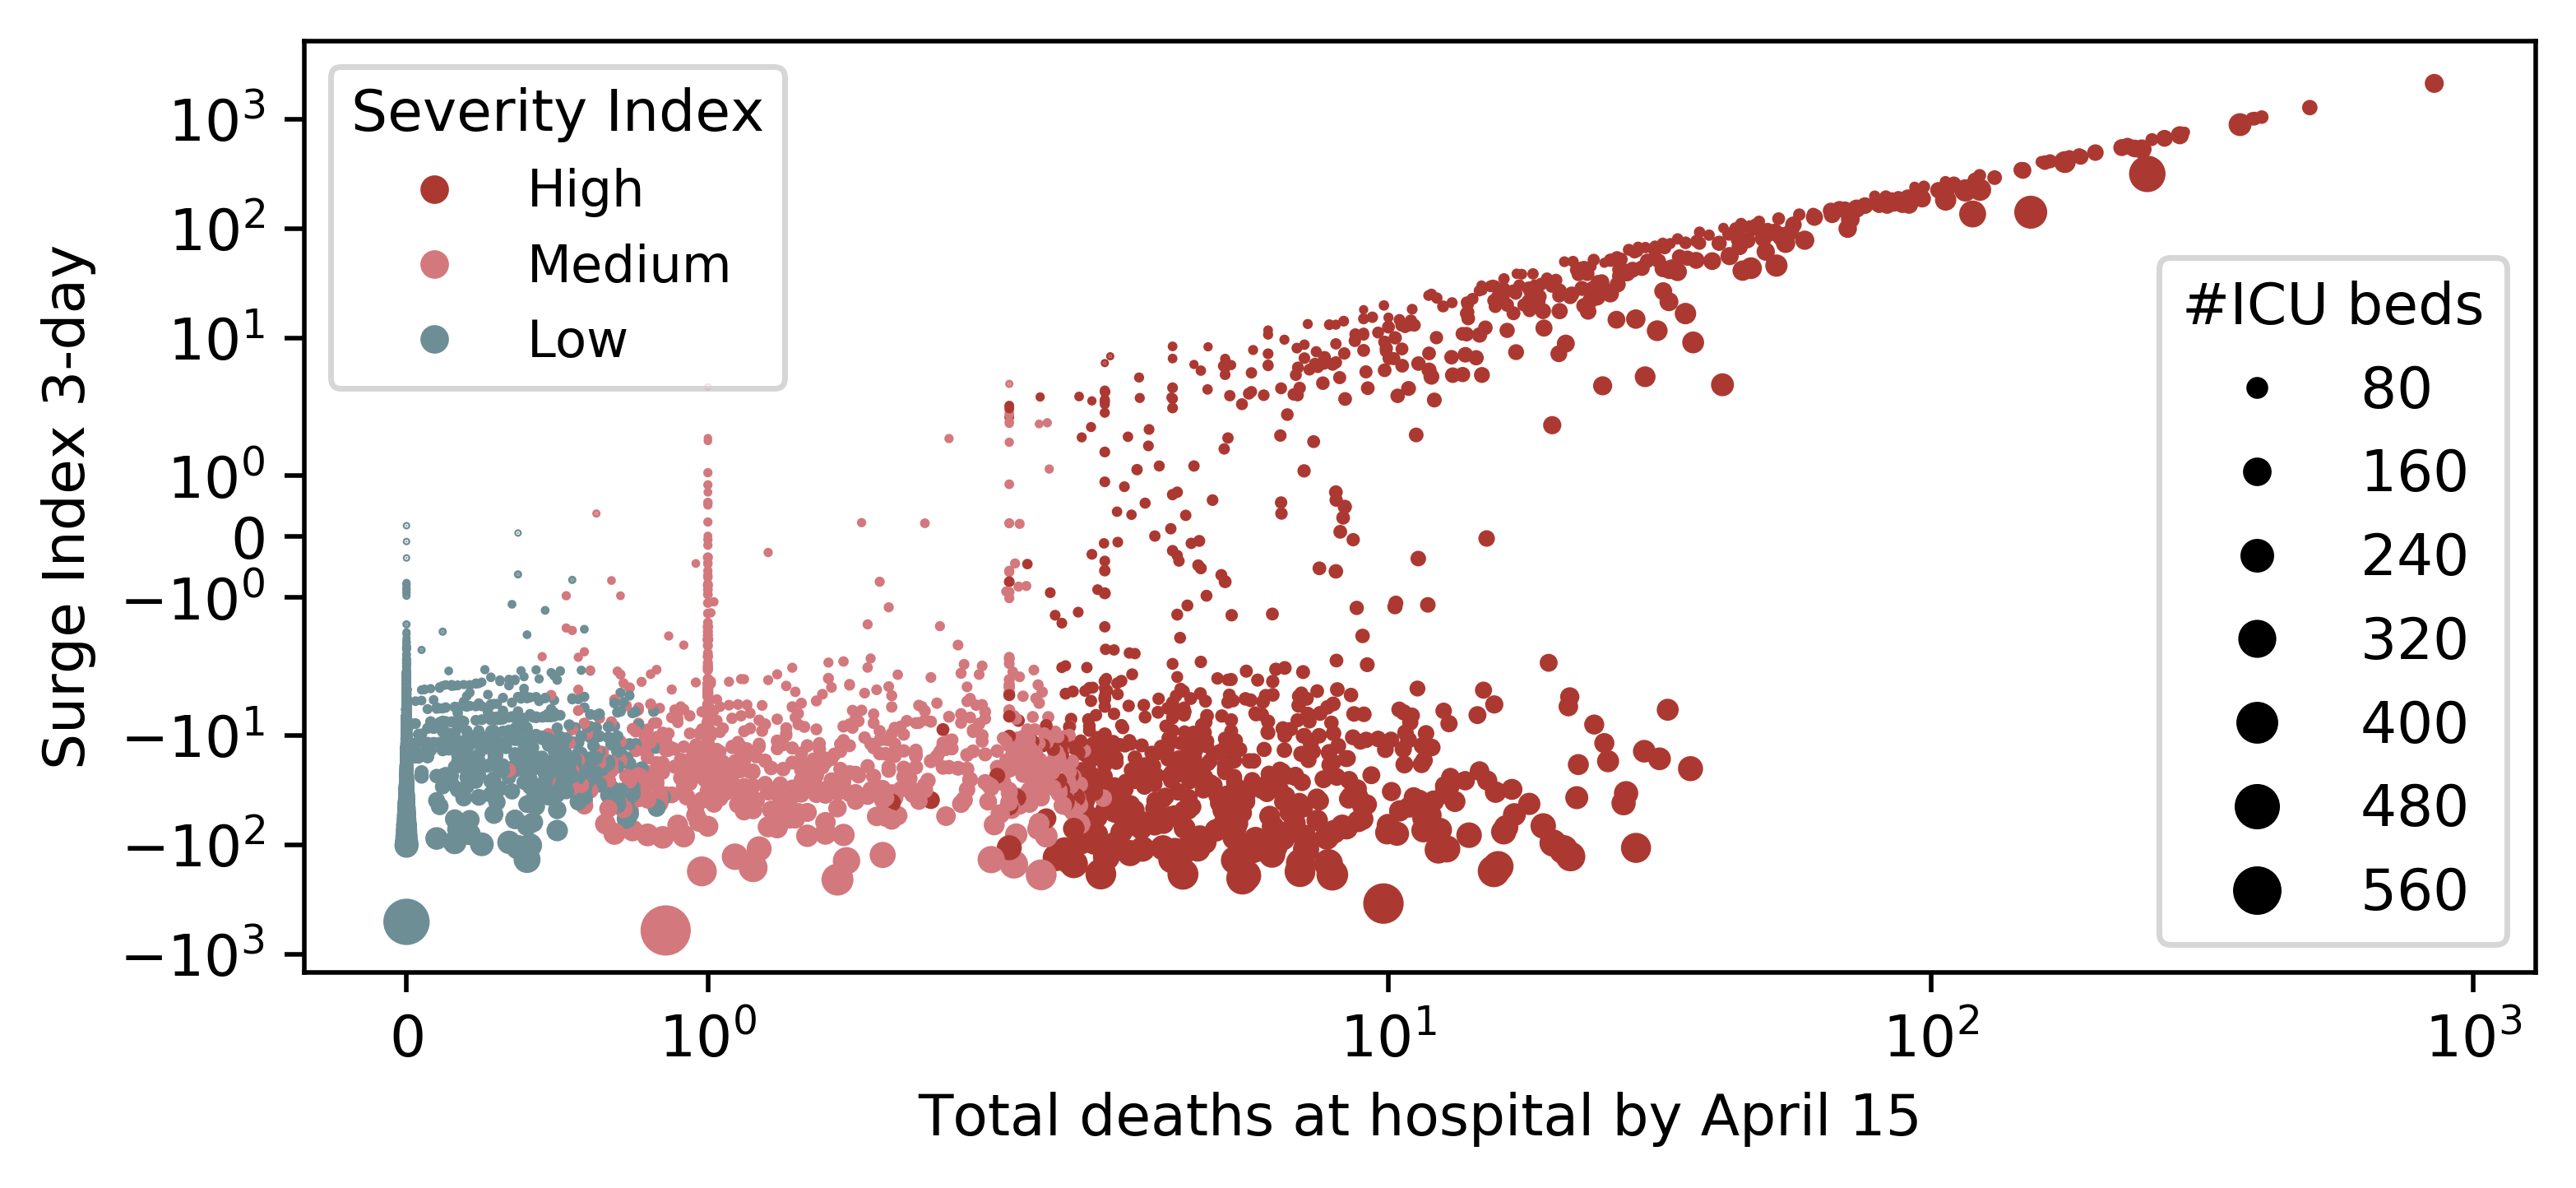

In [11]:
today = datetime.today().strftime("%B %d")
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
cs_d = {i: cs[i-1] for i in [1, 2, 3]}
# cs = ['#91bfdb','#dec34b','#fc8d59']
x = d['Total Deaths Hospital']
y = d['Surge 3-day']
c = [cs_d[x] for x in d['Severity 3-day']] # d['Severity 3-day'] #
s = d['ICU Beds'] / 10
fig, ax = plt.subplots(dpi=500, figsize=(7, 3))
scatter = ax.scatter(x, y, c=c, s=s, alpha=1)
plt.yscale('symlog')
plt.xscale('symlog')

# produce a legend with the unique colors from the scatter
leg_els = [Line2D([0], [0], marker='o', color='w', label='High', markerfacecolor=cs[2], markersize=6),
           Line2D([0], [0], marker='o', color='w', label='Medium', markerfacecolor=cs[1], markersize=6),
           Line2D([0], [0], marker='o', color='w', label='Low', markerfacecolor=cs[0], markersize=6)]

# leg_els = scatter.legend_elements()
# legend1 = ax.legend(*leg_els, loc="upper left", title="Severity Index")
legend1 = ax.legend(handles=leg_els, loc="upper left", title="Severity Index", fontsize=9)
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=1)
l2 = []
for i in range(len(labels)):
    s = labels[i]
    num = 10 * int(s[s.index('{') + 1: s.index('}')])
    l2.append('$\\mathdefault{' + str(num) + '}$')
legend2 = ax.legend(handles, l2, loc="lower right", title="#ICU beds")
plt.xlabel(f'Total deaths at hospital by {today}')
plt.ylabel('Surge Index 3-day')
plt.show()

In [ ]:
today = datetime.today().strftime("%B %d")
plt.figure(dpi=500, figsize=(7, 3))
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
x = 'Total Deaths Hospital'
y = 'Surge 3-day'

for i in [3, 2, 1]:
    dr = d[d['Severity 3-day']==i]
    plt.plot(dr[x], dr[y], '.',
             label=f'{remap[i]}', alpha=0.3, color=cs[i -1])

# plt.scatter(d[x], d[y], c=d['Severity 3-day'])
plt.xlabel(f'Total deaths at hospital by {today}')
plt.ylabel('Surge Index 3-day')
# plt.xscale('log')
# plt.yscale('log')
plt.yscale('symlog')
plt.xscale('symlog')
plt.legend(title='Severity Index')
plt.show()